In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

taxi = pd.read_csv("../data/raw/taxi.csv")


In [3]:
#EDA
taxi.head()
taxi.shape
taxi.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22699 entries, 0 to 22698
Data columns (total 18 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Unnamed: 0             22699 non-null  int64  
 1   VendorID               22699 non-null  int64  
 2   tpep_pickup_datetime   22699 non-null  object 
 3   tpep_dropoff_datetime  22699 non-null  object 
 4   passenger_count        22699 non-null  int64  
 5   trip_distance          22699 non-null  float64
 6   RatecodeID             22699 non-null  int64  
 7   store_and_fwd_flag     22699 non-null  object 
 8   PULocationID           22699 non-null  int64  
 9   DOLocationID           22699 non-null  int64  
 10  payment_type           22699 non-null  int64  
 11  fare_amount            22699 non-null  float64
 12  extra                  22699 non-null  float64
 13  mta_tax                22699 non-null  float64
 14  tip_amount             22699 non-null  float64
 15  to

In [4]:
taxi.duplicated().sum()
taxi.drop_duplicates(inplace=True)



In [5]:
taxi['tpep_pickup_datetime'] = pd.to_datetime(taxi['tpep_pickup_datetime'])
taxi['tpep_dropoff_datetime'] = pd.to_datetime(taxi['tpep_dropoff_datetime'])


In [6]:
taxi['trip_duration_min'] = (
    taxi['tpep_dropoff_datetime'] - taxi['tpep_pickup_datetime']
).dt.total_seconds() / 60


In [7]:
taxi = taxi[taxi['trip_duration_min'] > 0]


In [8]:
taxi.isnull().sum()


Unnamed: 0               0
VendorID                 0
tpep_pickup_datetime     0
tpep_dropoff_datetime    0
passenger_count          0
trip_distance            0
RatecodeID               0
store_and_fwd_flag       0
PULocationID             0
DOLocationID             0
payment_type             0
fare_amount              0
extra                    0
mta_tax                  0
tip_amount               0
tolls_amount             0
improvement_surcharge    0
total_amount             0
trip_duration_min        0
dtype: int64

In [9]:
taxi.duplicated().sum()
taxi.drop_duplicates(inplace=True)


In [10]:
taxi = taxi[(taxi['passenger_count'] > 0) & (taxi['passenger_count'] <= 6)]


In [11]:
taxi = taxi[taxi['trip_distance'] > 0]


In [12]:
taxi = taxi[(taxi['fare_amount'] > 0) & (taxi['total_amount'] > 0)]


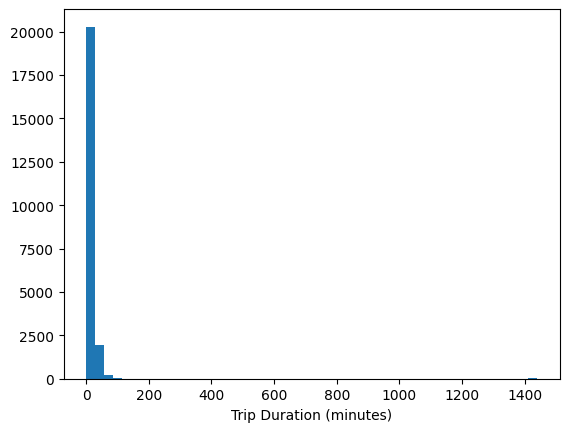

In [27]:
#VISUALS
plt.hist(taxi['trip_duration_min'], bins=50)
plt.xlabel("Trip Duration (minutes)")
plt.show()


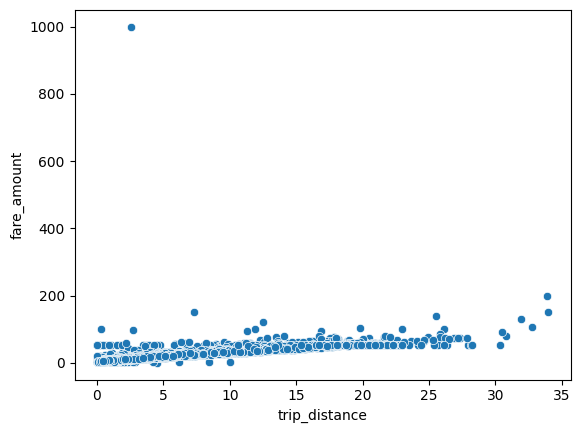

In [14]:
sns.scatterplot(x='trip_distance', y='fare_amount', data=taxi)
plt.show()


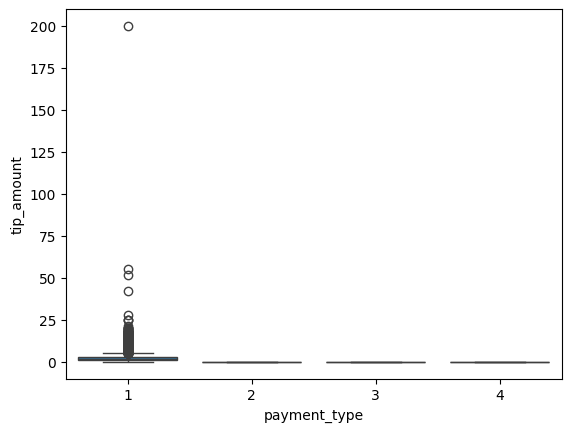

In [15]:
sns.boxplot(x='payment_type', y='tip_amount', data=taxi)
plt.show()


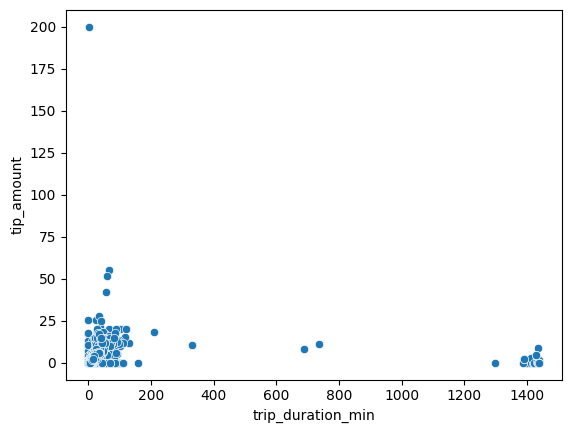

In [16]:
sns.scatterplot(x='trip_duration_min', y='tip_amount', data=taxi)
plt.show()


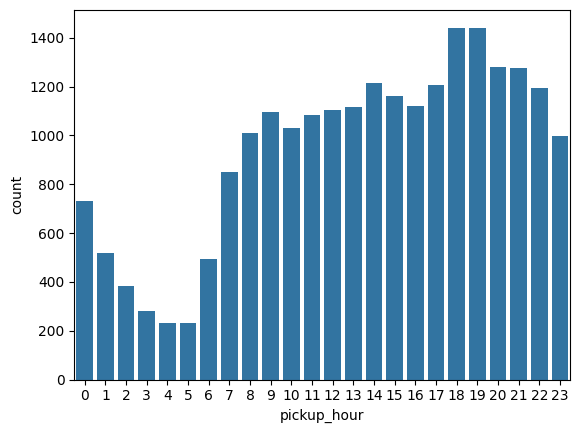

In [17]:
taxi['pickup_hour'] = taxi['tpep_pickup_datetime'].dt.hour

sns.countplot(x='pickup_hour', data=taxi)
plt.show()


In [26]:
#EDA DATA CLEANED
taxi.to_csv("../data/cleaned/taxi_cleaned.csv", index=False)


In [20]:
#DATA ENGINEERING
taxi['cost_per_km'] = taxi['total_amount'] / taxi['trip_distance']


In [21]:
taxi['tip_ratio'] = taxi['tip_amount'] / taxi['total_amount']
taxi['tip_ratio'].fillna(0, inplace=True)


C:\Users\adhit\AppData\Local\Temp\ipykernel_25536\3578484071.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  taxi['tip_ratio'].fillna(0, inplace=True)


In [22]:
taxi['long_trip_flag'] = (taxi['trip_duration_min'] > taxi['trip_duration_min'].median()).astype(int)


In [23]:
taxi['pickup_hour'] = taxi['tpep_pickup_datetime'].dt.hour

taxi['peak_hour'] = taxi['pickup_hour'].apply(
    lambda x: 1 if (7 <= x <= 10 or 16 <= x <= 19) else 0
)


In [25]:
#STORE ENGINEERED DATA
taxi.to_csv("../data/cleaned/taxi_features.csv", index=False)


MACHINE LEARNING REGRESSION MODEL - Predict satisfaction proxy (tip ratio)TRAINING

In [28]:
#MODEL TRAINING (REGRESSION )
3DATA PREPARATION
from sklearn.model_selection import train_test_split

taxi = pd.read_csv("../data/cleaned/taxi_features.csv")

features = [
    'trip_distance',
    'trip_duration_min',
    'cost_per_km',
    'peak_hour'
]

X = taxi[features]
y = taxi['tip_ratio']


In [29]:
#TRAIN
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)


In [30]:
#(Linear Regression)
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, r2_score

model_taxi = LinearRegression()
model_taxi.fit(X_train, y_train)


LinearRegression()

In [32]:
#VALUATION
y_pred = model_taxi.predict(X_test)

print("MAE:", mean_absolute_error(y_test, y_pred))
print("R2:", r2_score(y_test, y_pred))


MAE: 0.07740654940813531
R2: 0.0005938336341503314


#INSIGHT OBSERVED- Longer trips and higher cost per km reduce customer satisfaction (lower tips)

In [33]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
import joblib

# Load cleaned data
taxi = pd.read_csv("../data/cleaned/taxi_features.csv")

X = taxi[['trip_distance','trip_duration_min','cost_per_km','peak_hour']]
y = taxi['tip_ratio']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

model_taxi = LinearRegression()
model_taxi.fit(X_train, y_train)

# SAVE MODEL
joblib.dump(model_taxi, "../models/taxi_model.pkl")


['../models/taxi_model.pkl']